 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

train set size: 60000
test set size: 10000

train labels distribution: Counter({9.0: 6000, 0.0: 6000, 3.0: 6000, 2.0: 6000, 7.0: 6000, 5.0: 6000, 1.0: 6000, 6.0: 6000, 4.0: 6000, 8.0: 6000})
test labels distribution: Counter({9.0: 1000, 2.0: 1000, 1.0: 1000, 6.0: 1000, 4.0: 1000, 5.0: 1000, 7.0: 1000, 3.0: 1000, 8.0: 1000, 0.0: 1000})

image examples:


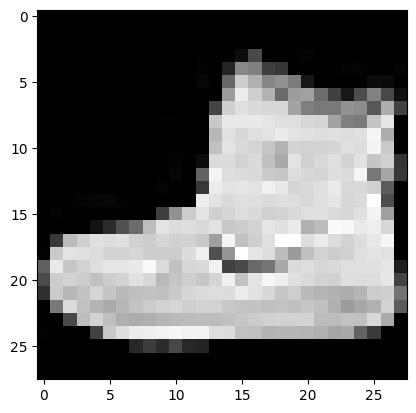

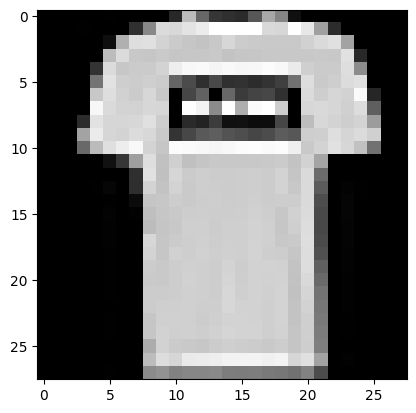

In [3]:
import collections

def plot_image(image, label=None):
    if label is not None:
        print(f'{label}:')
    plt.imshow(image, cmap='gray')
    plt.show()

X_train = trainset.data.double()
X_test = testset.data.double()
y_train = trainset.targets.double()
y_test = testset.targets.double()

# Сколько картинок в train? В test?
print(f'train set size: {X_train.shape[0]}')
print(f'test set size: {X_test.shape[0]}\n')

# Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
print(f'train labels distribution: {collections.Counter(y_train.numpy())}')
print(f'test labels distribution: {collections.Counter(y_test.numpy())}\n')

print('image examples:')
for i in range(2):
    plot_image(X_train[i])

In [4]:
import torch.nn as nn

n = X_train.shape[-1] * X_train.shape[-2]

class Model(nn.Module):
    def __init__(self, hidden_layer_neurons, dropout_prob, dropout_layer_freq, input_dropout=False):
        super().__init__()

        self.hidden_layer_neurons = hidden_layer_neurons

        self.layers = []
        if input_dropout:
            self.layers.append(nn.Dropout(dropout_prob))
        self.layers.append(nn.Linear(n, hidden_layer_neurons[0]).double())
        for i in range(len(hidden_layer_neurons)-1):
            self.layers.append(nn.Linear(hidden_layer_neurons[i], hidden_layer_neurons[i+1]).double())
            if i != 0 and i % dropout_layer_freq == 0:
                self.layers.append(nn.Dropout(dropout_prob))
        self.layers.append(nn.Linear(hidden_layer_neurons[-1], len(classes)).double())
                
        for i, layer in enumerate(self.layers, start=1):
            self.__setattr__(f'layer{i}', layer)

        self.activation = nn.LeakyReLU()
        self.end_activation = nn.Softmax(dim=1)
 
    def forward(self, x):
        for layer in self.layers[:-1]:
            if isinstance(layer, nn.Dropout):
                x = layer(x)
            else:
                x = self.activation(layer(x))

        x = self.end_activation(self.layers[-1](x))
        
        return x

In [5]:
import copy
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, train_test_split

def train_model(model, X_train, y_train, X_test, y_test):
    global epochs, batch_size, learning_rate, momentum

    losses = []
    accuracies = []

    best_accuracy = 0
    best_weights = None
    
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    batch_starts = torch.arange(0, len(X_train), batch_size)

    for _ in range(epochs):
        model.train()
        for batch_start in batch_starts:
            X_batch = X_train[batch_start:batch_start+batch_size]
            y_true_batch = y_train[batch_start:batch_start+batch_size]
            y_pred = model(X_batch)
            y_true_batch_probs = torch.zeros((batch_size,len(classes)))
            y_true_batch_probs[torch.arange(batch_size), y_true_batch.int()] = 1.
            loss = loss_fn(y_pred, y_true_batch_probs.double())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval()
        y_pred = model(X_test)
        accuracy = (y_pred.argmax(dim=1) == y_test).float().sum().item() / len(X_test)

        losses.append(loss.item())
        accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_weights)
    return model, losses, accuracies

In [6]:
X_train_flatten = X_train.view(X_train.shape[0], n).type(torch.float64)
X_test_flatten = X_test.view(X_test.shape[0], n).type(torch.float64)

In [7]:
batch_size = 64
epochs = 25
learning_rate = 0.001
momentum = 0.8
loss_fn = nn.CrossEntropyLoss()

# Kfold - use (n-1) folds for training and 1 fold for testing with new test fold each time to better evaulate performance
# Mb test and compare with regular KFold since input data is already balanced.
kfold = StratifiedKFold(n_splits=5, shuffle=True) # StratifiedKFold ensures that each fold has the same proportion of observations with each label
best_mlp_model = None
total_losses = []
total_accuracies = []
for train_idxs, test_idxs in kfold.split(X_train, y_train):    
    model = Model(
        hidden_layer_neurons=[512, 256, 128, 64], 
        dropout_prob=0.1,
        dropout_layer_freq=2,
        input_dropout=True)
    best_mlp_model, losses, accuracies = train_model(model, X_train_flatten[train_idxs], y_train[train_idxs], X_train_flatten[test_idxs], y_train[test_idxs])
    total_losses.append(losses)
    total_accuracies.append(accuracies)

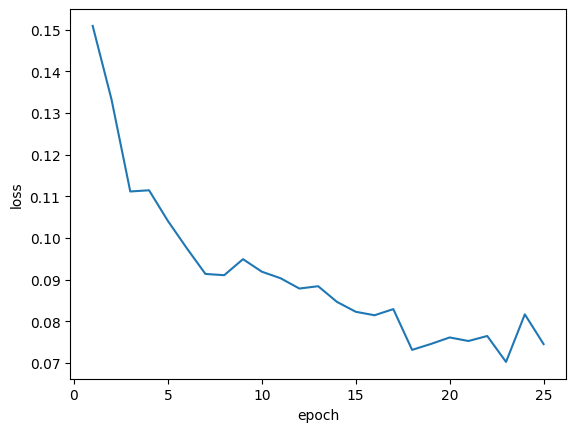

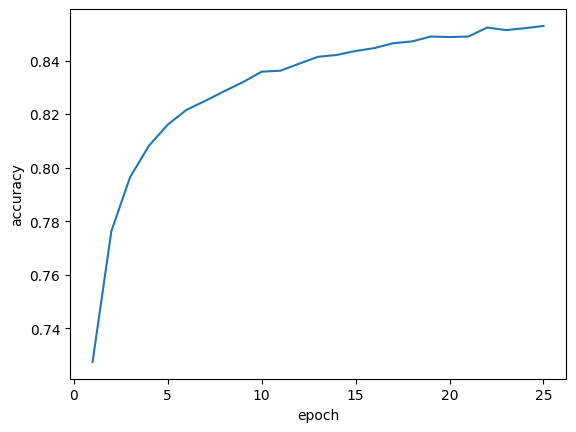

In [9]:
def plot_line(x, y, xlabel, ylabel):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

mean_losses = np.array(total_losses).mean(axis=0)
mean_accuracies = np.array(total_accuracies).mean(axis=0)

epochs_list = range(1, epochs+1)
plot_line(epochs_list, mean_losses, 'epoch', 'loss')
plot_line(epochs_list, mean_accuracies, 'epoch', 'accuracy')

In [15]:
# Compute accuracy for test dataset using last trained model

best_mlp_model.eval()
y_pred = model(X_test_flatten)
accuracy = (y_pred.argmax(dim=1) == y_test).float().sum().item() / len(X_test)

print(f'accuracy on test data: {accuracy}')

accuracy on test data: 0.8454


In [18]:
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [29]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [46]:
def train_model(model, X_train, y_train, X_test, y_test):
    global epochs, batch_size, learning_rate, momentum

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    accuracies = []

    best_accuracy = 0
    best_weights = None
    
    batch_starts = torch.arange(0, len(X_train), batch_size)

    for _ in range(epochs):
        model.train()
        for batch_start in batch_starts:
            X_batch = X_train[batch_start:batch_start+batch_size]
            y_true_batch = y_train[batch_start:batch_start+batch_size]

            X_batch = Variable(X_batch.view(batch_size, 1, 28, 28))
            y_true_batch = Variable(y_true_batch)
            y_true_batch_probs = torch.zeros((batch_size,len(classes)))
            y_true_batch_probs[torch.arange(batch_size), y_true_batch.int()] = 1.
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_true_batch_probs.double())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        y_pred = model(X_test.view(X_test.shape[0], 1, 28, 28))
        accuracy = (y_pred.argmax(dim=1) == y_test).float().sum().item() / len(X_test)

        losses.append(loss.item())
        accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_weights)
    return model, losses, accuracies

In [38]:
X_train = X_train.double()
X_test = X_test.double()
y_train = y_train.double()
y_test = y_test.double()

In [45]:
batch_size = 64
epochs = 5
learning_rate = 0.001
momentum = 0.8

kfold = StratifiedKFold(n_splits=3, shuffle=True)
best_cnn_model = None
total_losses = []
total_accuracies = []
for train_idxs, test_idxs in kfold.split(X_train, y_train):    
    model = Model()
    best_cnn_model, losses, accuracies = train_model(
        model, 
        X_train[train_idxs], 
        y_train[train_idxs], 
        X_train[test_idxs], 
        y_train[test_idxs])
    total_losses.append(losses)
    total_accuracies.append(accuracies)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(

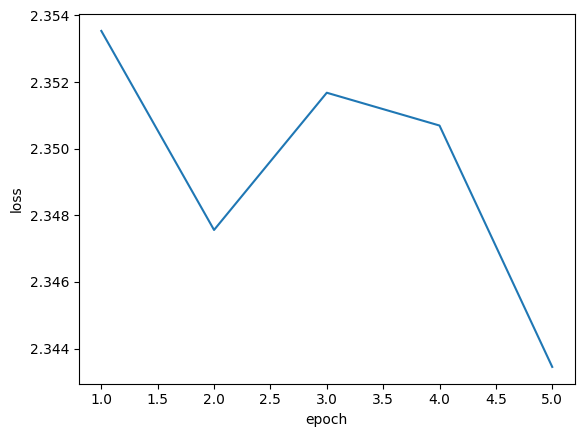

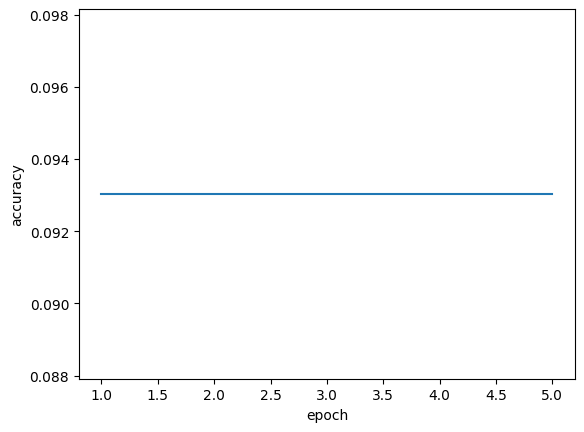

In [47]:
mean_losses = np.array(total_losses).mean(axis=0)
mean_accuracies = np.array(total_accuracies).mean(axis=0)

epochs_list = range(1, epochs+1)
plot_line(epochs_list, mean_losses, 'epoch', 'loss')
plot_line(epochs_list, mean_accuracies, 'epoch', 'accuracy')

In [ ]:
best_cnn_model.eval()
y_pred = model(X_test_flatten)
accuracy = (y_pred.argmax(dim=1) == y_test).float().sum().item() / len(X_test)

print(f'accuracy on test data: {accuracy}')